Прогнозирование оттока клиентов фитнес-центра.

Оглавление

- Описание проекта
- Получение исходных данных
- Исследовательский анализ данных EDA
- Формирование прогнозной модели на основе логистической регрессии
- Формирование прогнозной модели на основе RandomForestClassifier
- Категоризация клиентов
- Рекомендации для маркетинговой стратегии по группам клиентов
- Описание проекта

Исходные данные представляют собой информацию о клиентах фитнес-центра. Основная проблема - отток клиентов. Задачи:

- Сформировать модель прогнозирования оттока (на уровне следующего месяца);
- Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- Проанализировать основные признаки, наиболее сильно влияющие на отток;
- Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

In [6]:
!pip install ydata_profiling

In [2]:
import pandas as pd
import datetime as dt #не работал
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats # не работал
from ydata_profiling import ProfileReport # не работал
%matplotlib inline
import seaborn as sns # не работал
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage # не работал
from sklearn.preprocessing import StandardScaler

In [3]:
df=pd.read_csv("gym_churn.csv")

In [4]:
df.shape

(4000, 14)

In [5]:
df.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [6]:
ProfileReport(df, minimal = True) # Формирование отчета для исследования данных

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df.mean() # расчет средних значений признаков для тех кто ушел и остался

gender                                 0.510250
Near_Location                          0.845250
Partner                                0.486750
Promo_friends                          0.308500
Phone                                  0.903500
Contract_period                        4.681250
Group_visits                           0.412250
Age                                   29.184250
Avg_additional_charges_total         146.943728
Month_to_end_contract                  4.322750
Lifetime                               3.724750
Avg_class_frequency_total              1.879020
Avg_class_frequency_current_month      1.767052
Churn                                  0.265250
dtype: float64

In [9]:
df.groupby(by = "Churn").mean() 

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [10]:
left = df.query("Churn == 1") # Разделение данных на две группы: отток и активные клиенты
stay = df.query("Churn == 0")

In [11]:
def col(i): # функция, которая формирует графики распредлений признаков по категориям "остались/ушли"
    pivo = pd.pivot_table(data = df, index = 'Churn', columns = df.iloc[:,i], values ='Age', aggfunc = 'count').reset_index()
    pivo.columns=['Churn',df.columns[i]+'_0', df.columns[i]+'_1']
    m=plt.bar(x = pivo['Churn']-0.1, height = pivo.iloc[:,1], width = 0.2, label = pivo.columns[1])
    w=plt.bar(x = pivo['Churn']+0.1, height = pivo.iloc[:,2], width = 0.2, label = pivo.columns[2])
    plt.xticks(ticks = [0,1], labels = ['остались','отток'])
    plt.legend()
    plt.bar_label(m)
    plt.bar_label(w)
    plt.show() 

In [12]:
categ=pd.Series([0,1,2,3,4,6]) # номера колонок с категориальными значениями

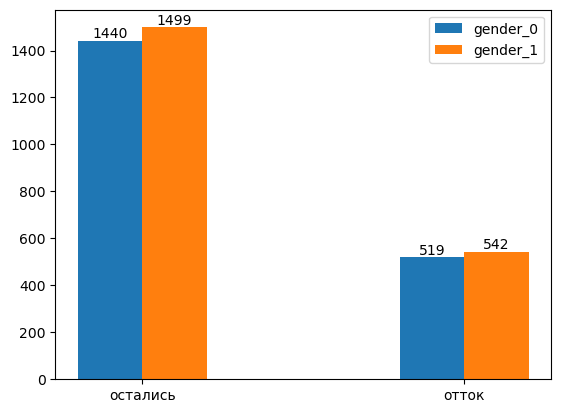

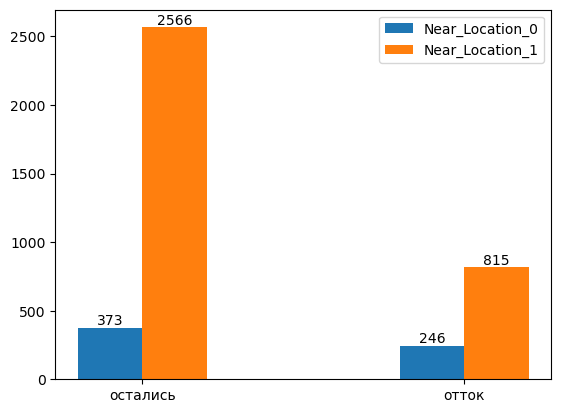

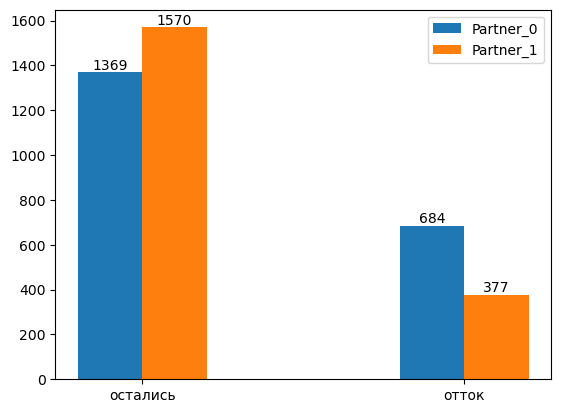

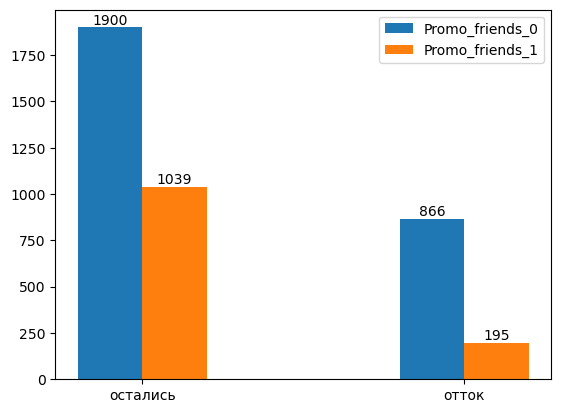

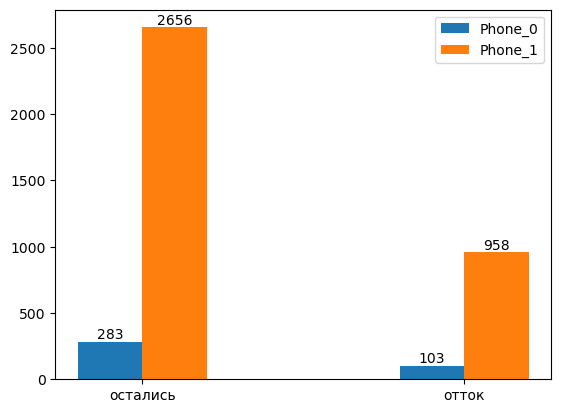

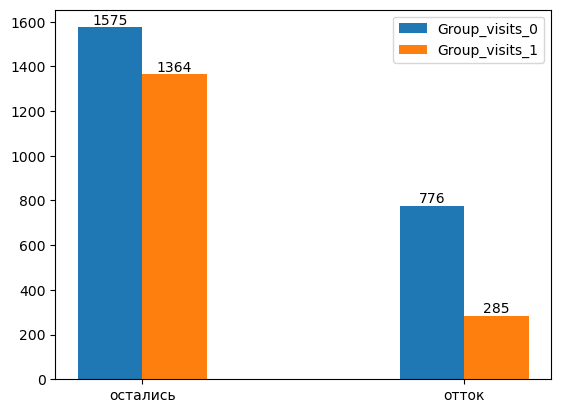

In [13]:
for i in categ:
    col(i) # построение бинарных распределений для категориальных данных в разбивке по группам "остались/ушли"

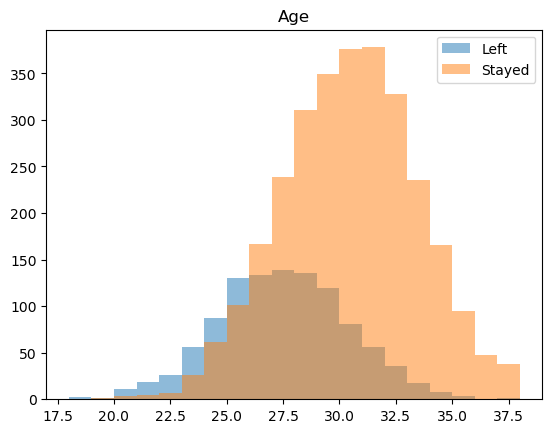

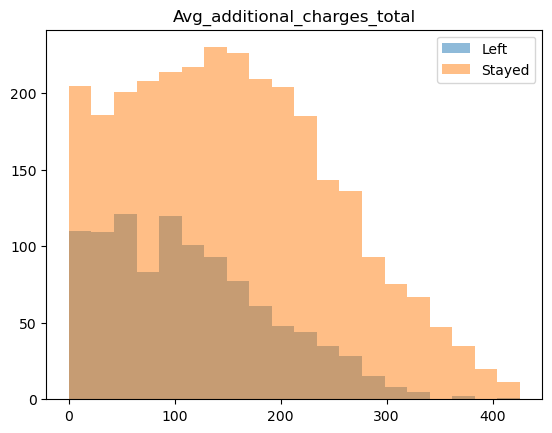

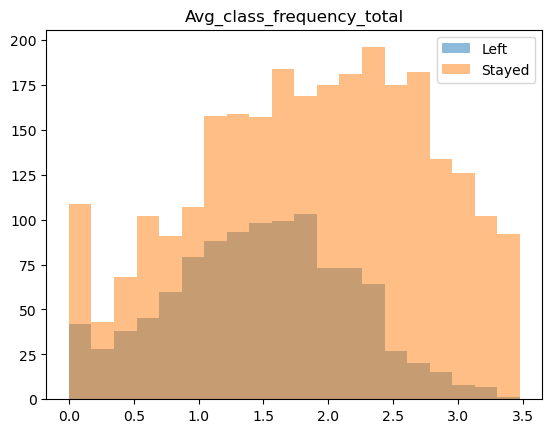

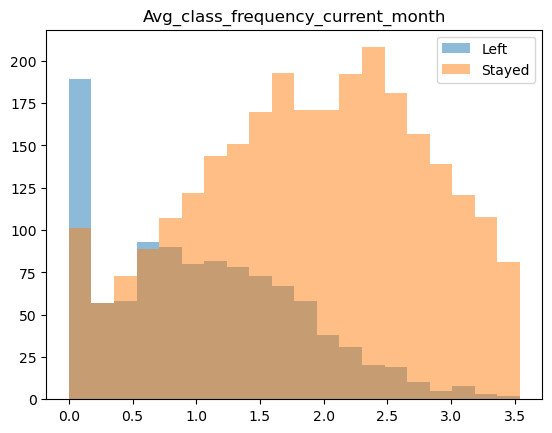

In [18]:
categ2 = pd.Series([7,8,11,12])
for i in categ2:
    n,bins, patches = plt.hist(left.iloc[:,i], bins = 20, alpha = 0.5, label = 'Left')
    plt.hist(stay.iloc[:,i], bins = bins,alpha = 0.5, label = 'Stayed')
    plt.legend()
    plt.title(left.columns[i])
    plt.show()

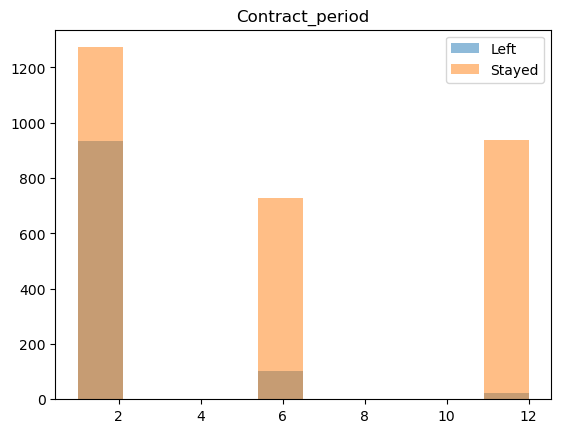

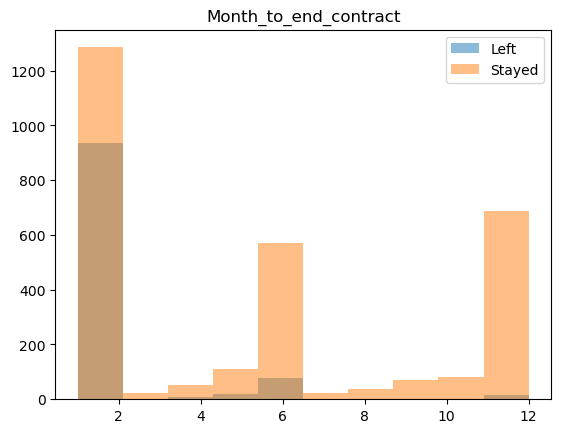

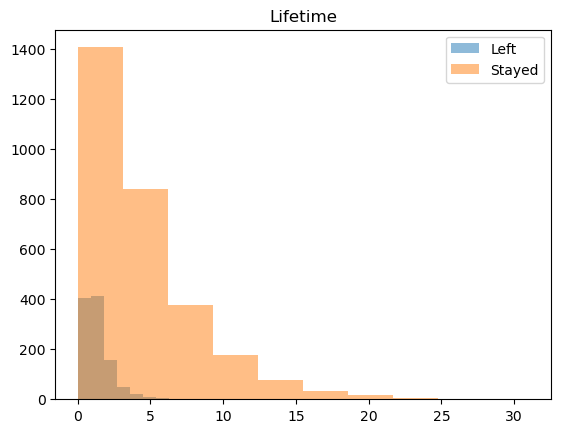

In [19]:
categ3 = pd.Series([5,9,10]) # номера колонок с дискретными признаками
for i in categ3: # построение графиков для дискретных признаков
    plt.hist(left.iloc[:,i], alpha = 0.5, label = 'Left')
    plt.hist(stay.iloc[:,i], alpha = 0.5, label = 'Stayed')
    plt.legend()
    plt.title(left.columns[i])
    plt.show()

In [20]:
cor = df.corr() # матрица корреляций
fig, ax = plt.subplots(figsize=(15,5)) 
sns.heatmap(cor, annot = True, fmt = ".2f") # тепловая карта на основе матрицы корреляций

<Axes: >

In [21]:
X = df.drop('Churn', axis = 1)
y=df['Churn'] # разделение данных на признаки (матрица X) и целевую переменную (y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0) # разделение модели на обучающую и валидационную выборку
model = LogisticRegression(max_iter = 1000)  
model.fit(X_train,y_train)
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, predictions)
precision = precision_score (y_test, predictions)
recall = recall_score (y_test, predictions)
print(acc, precision, recall) # вывод на экран метрик, характеризующих качество модели

0.92375 0.8586387434554974 0.8282828282828283


In [22]:
rf_model = RandomForestClassifier(n_estimators = 100)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test) 
acc_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score (y_test, y_pred)
recall_rf = recall_score (y_test, y_pred)
print(acc_rf, precision_rf, recall_rf)# вывод на экран метрик, характеризующих качество модели

0.92 0.845360824742268 0.8282828282828283


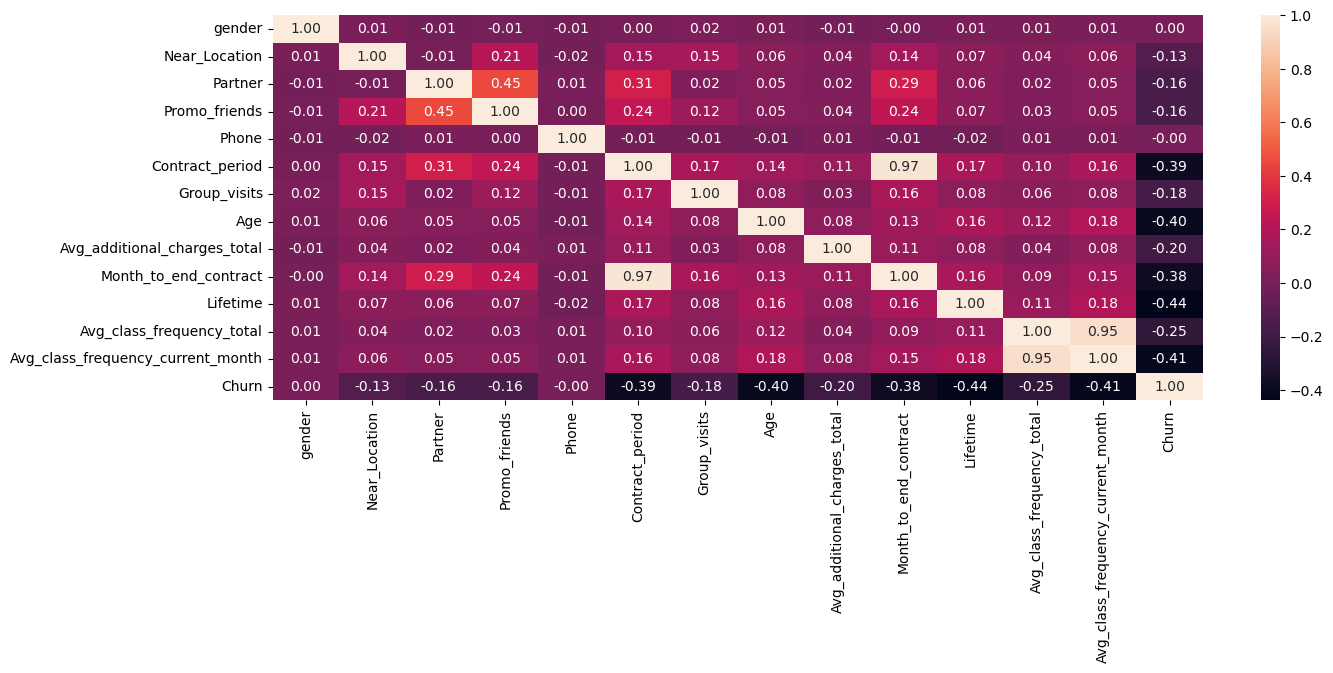

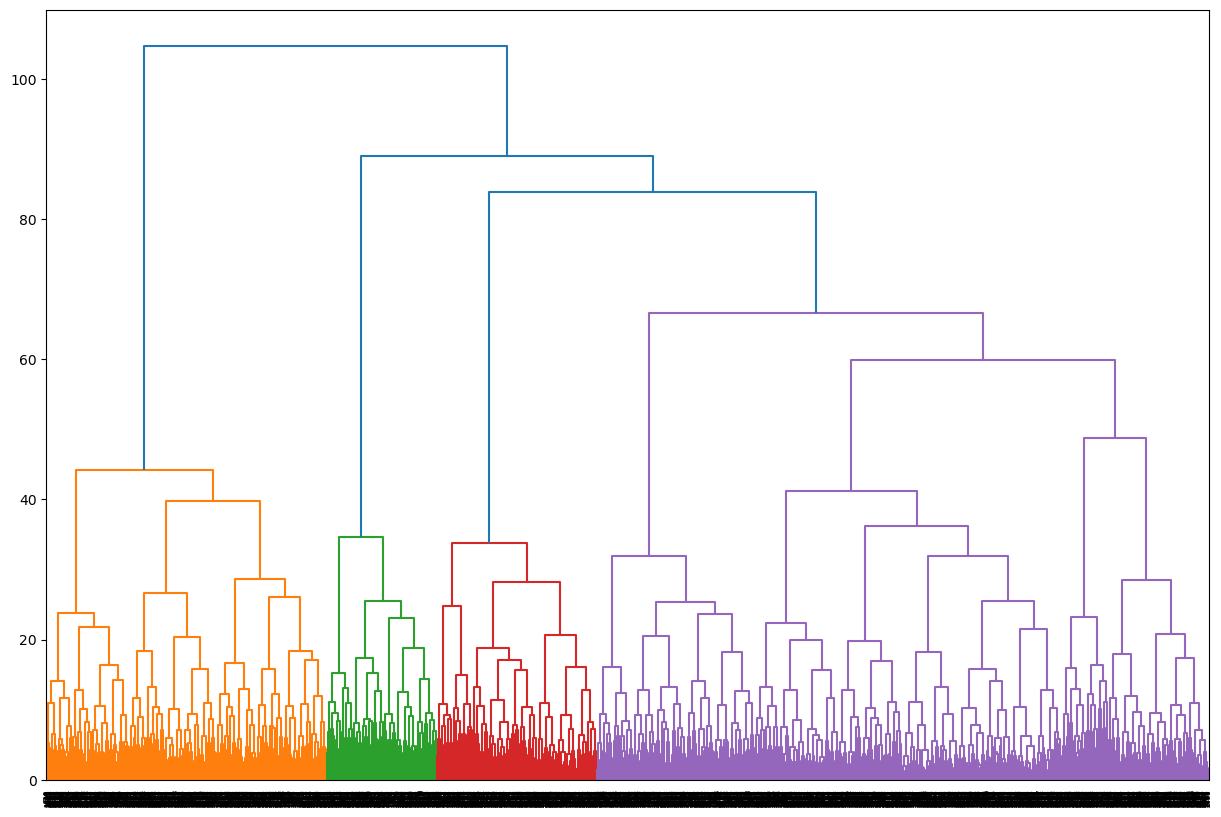

In [23]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() # вывод на экран дендрограммы

In [24]:
cl = 4 # количество кластеров выбранов соответствии с дендрограммой, а также на основе анализа нескольких вариантов
km = KMeans(n_clusters = cl)
labels = km.fit_predict(X_sc)

In [25]:
df['claster']= labels # добавление колонки с категориями

In [26]:
piv = pd.pivot_table(data = df, index = 'claster', columns = 'Churn', values = 'Age', aggfunc = 'count' ).reset_index() # формирование сводной таблицы для анализа оттока по категориям
piv.columns = ['claster','Churn_0','Churn_1']
piv['perc'] = piv['Churn_1']/(piv['Churn_0']+piv['Churn_1'])
piv['number']=piv['Churn_1']+piv['Churn_0']
print(piv.head())

   claster  Churn_0  Churn_1      perc  number
0        0      648       44  0.063584     692
1        1      970      109  0.101019    1079
2        2      608      893  0.594937    1501
3        3      713       15  0.020604     728


In [33]:
left = df.query('Churn == 1')
stay = df.query('Churn == 0')

In [35]:
categ_cat = pd.Series(np.arange(0,cl,1))
print(categ_cat)
print(categ2)

0    0
1    1
2    2
3    3
dtype: int64
0     7
1     8
2    11
3    12
dtype: int64


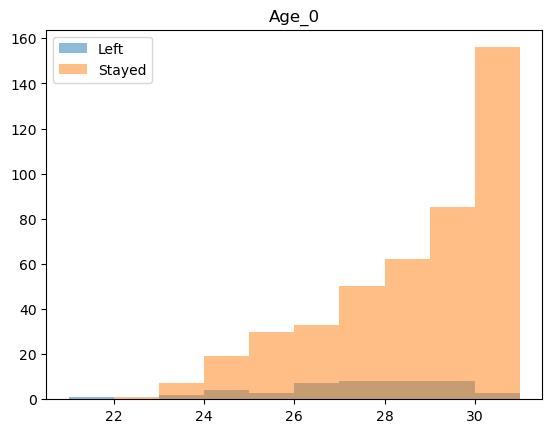

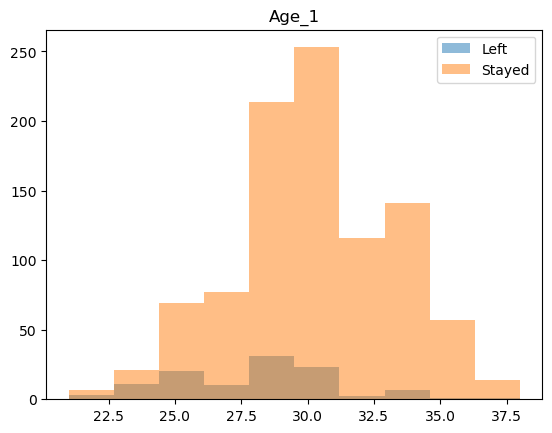

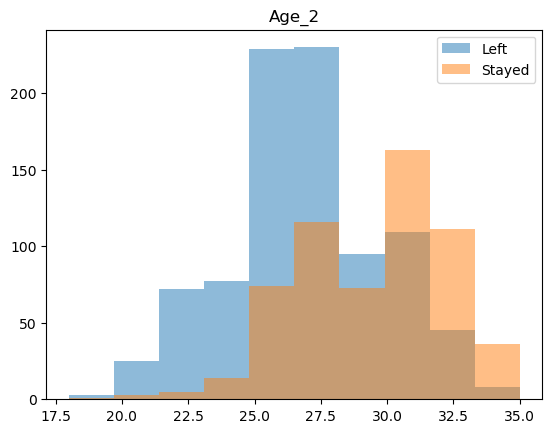

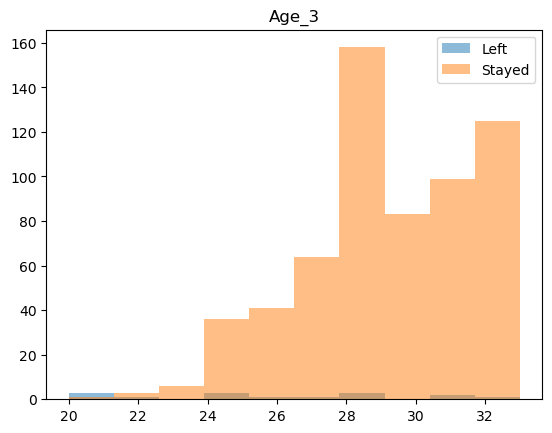

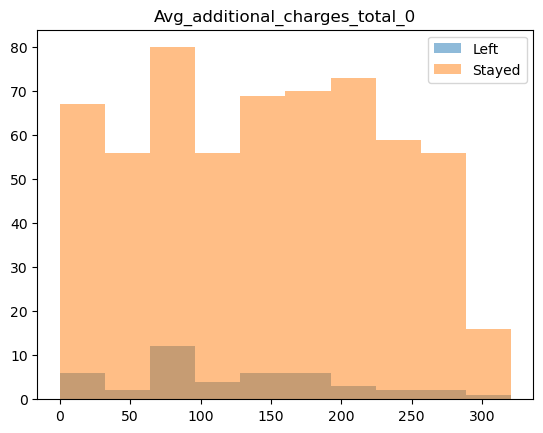

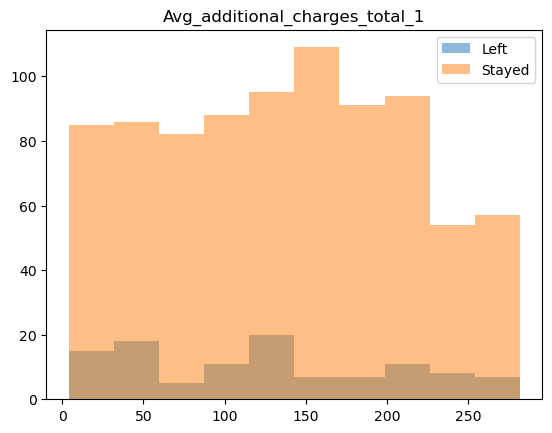

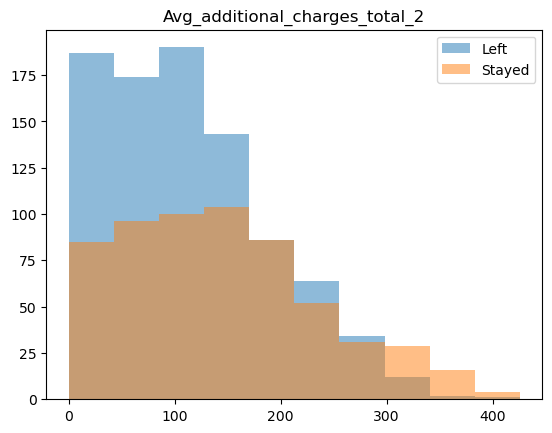

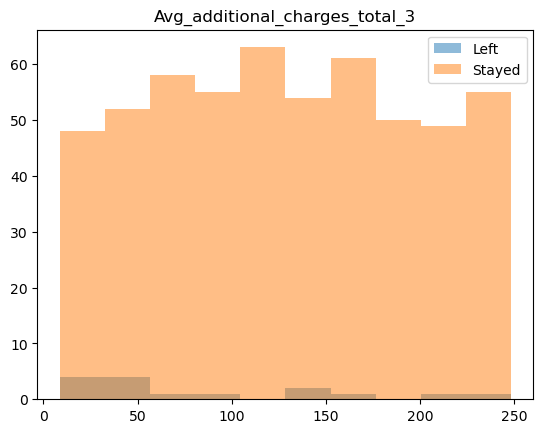

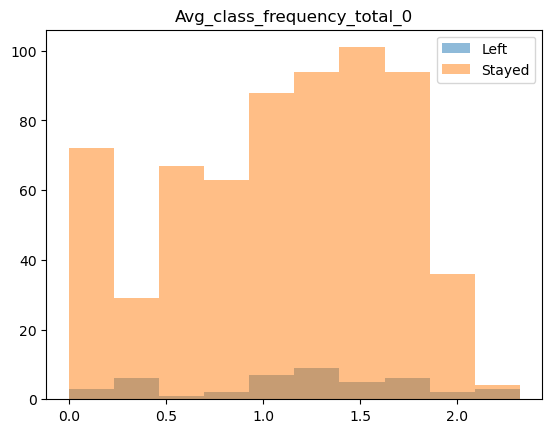

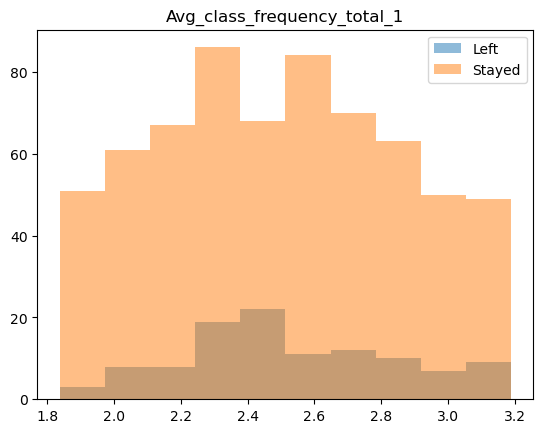

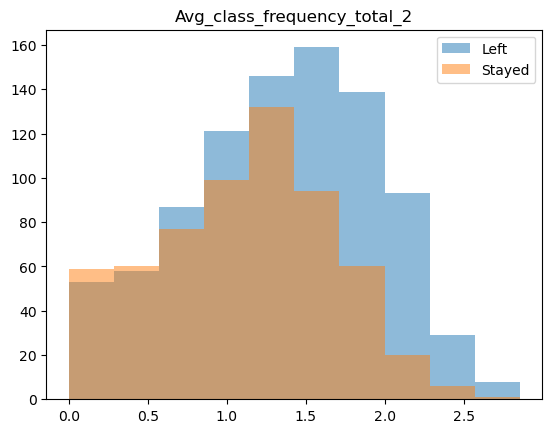

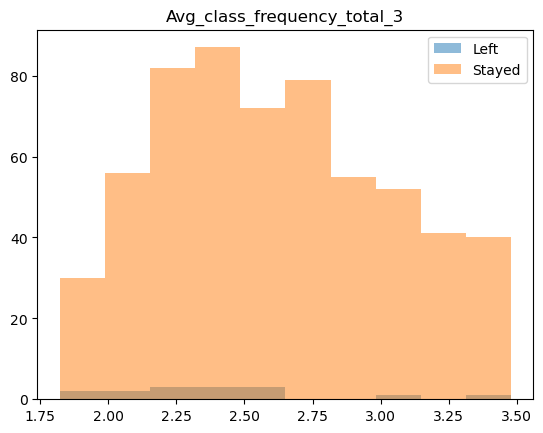

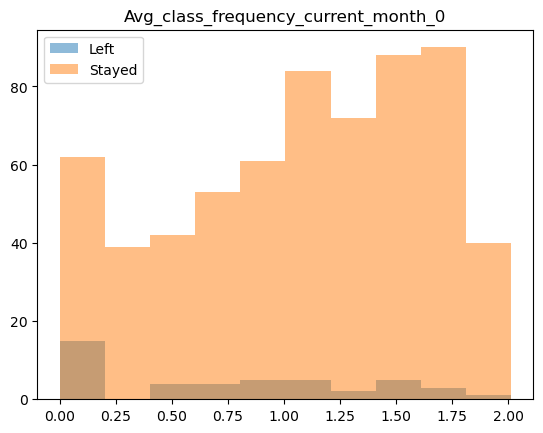

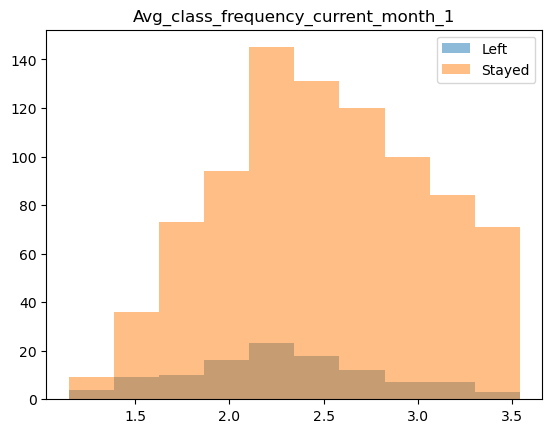

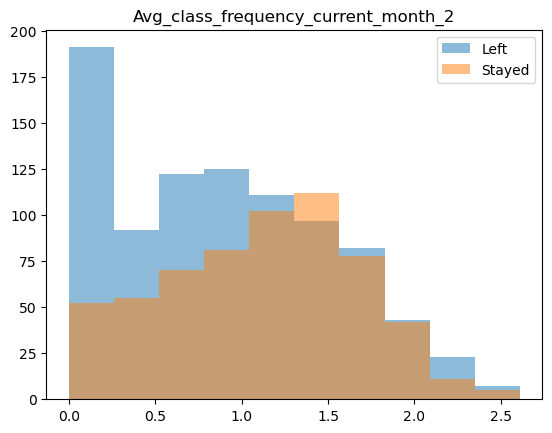

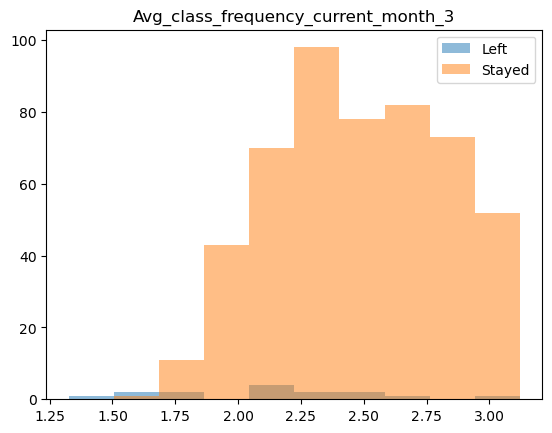

In [36]:
for i in categ2:
    for j  in categ_cat:
        n,bins, patches = plt.hist(left[left['claster'] == j].iloc[:,i], bins = 10, alpha = 0.5, label = 'Left')
        plt.hist(stay[stay['claster'] == j].iloc[:,i], bins = bins,alpha = 0.5, label = 'Stayed')
        plt.legend()
        plt.title(left.columns[i]+'_%i' %j)
        plt.show()

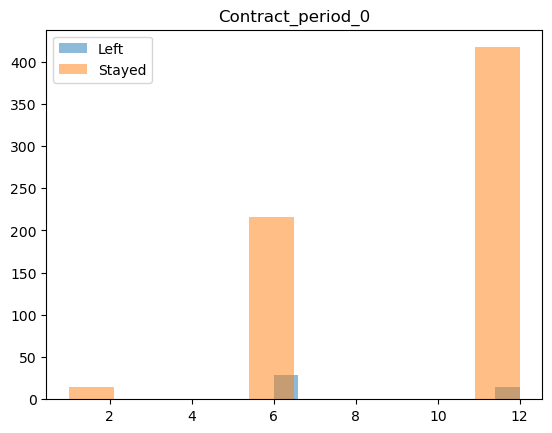

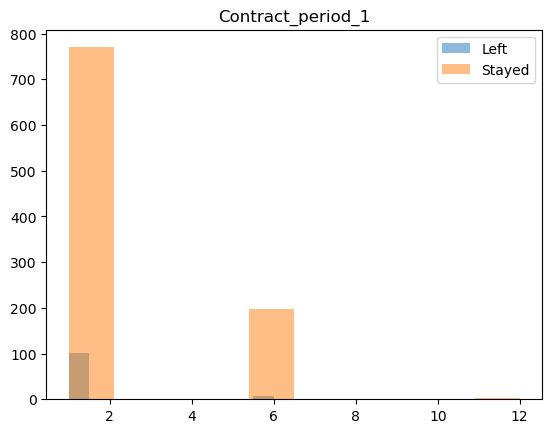

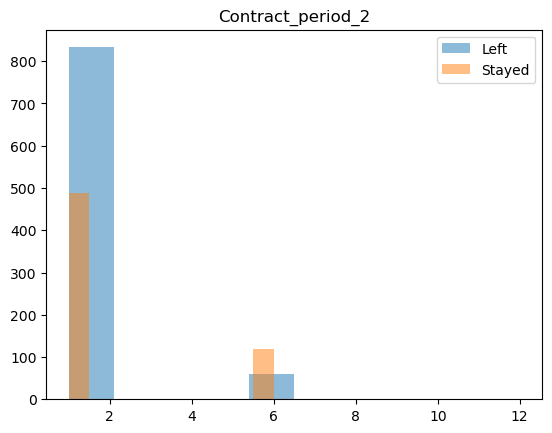

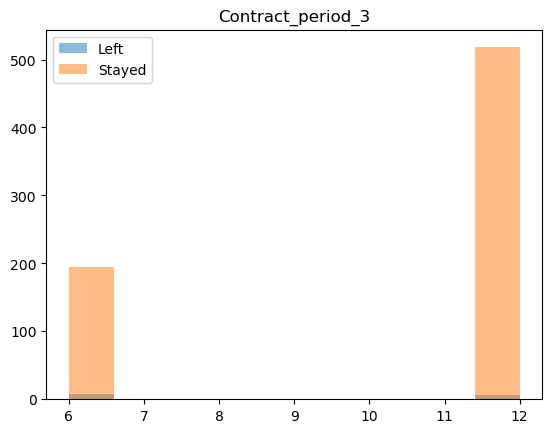

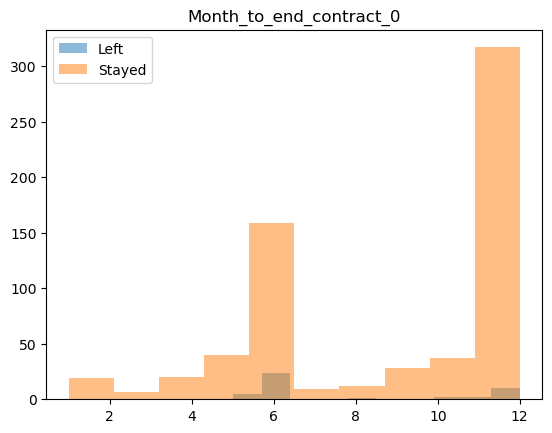

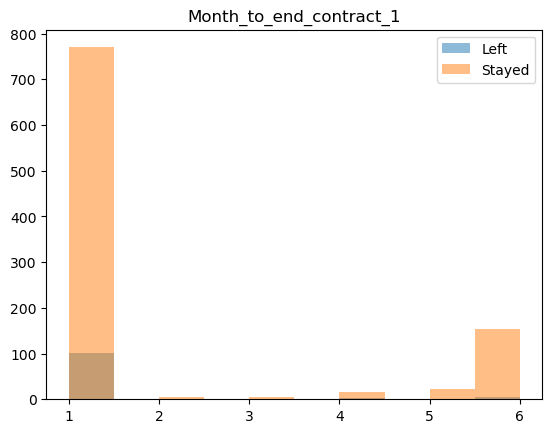

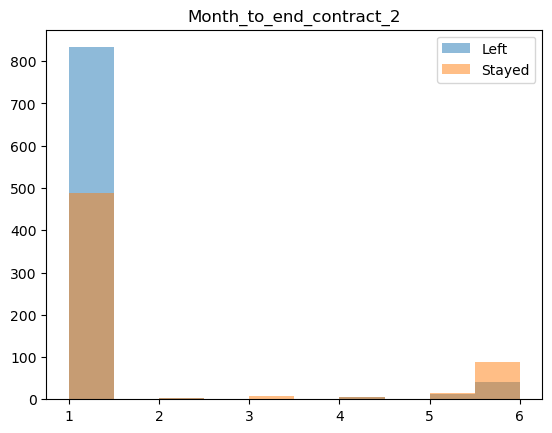

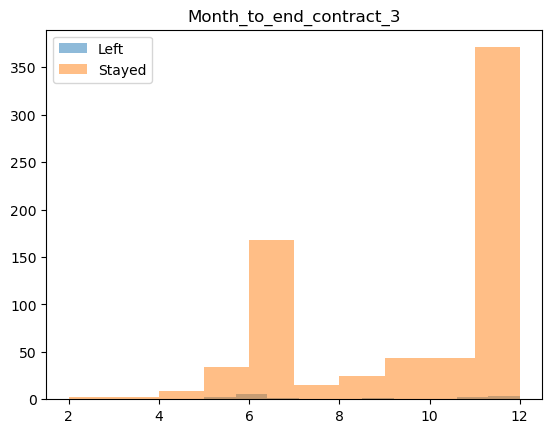

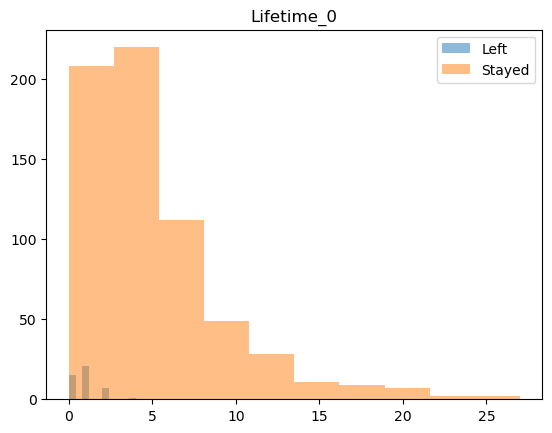

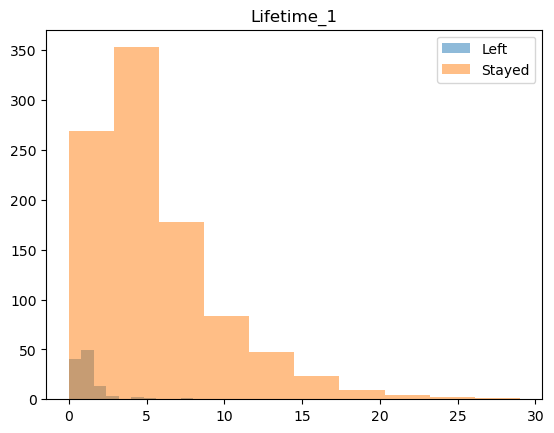

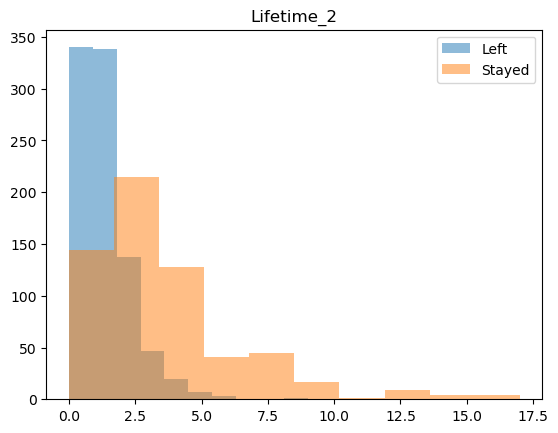

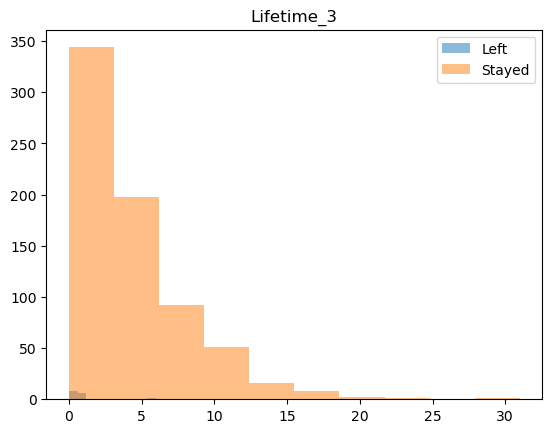

In [38]:
for i in categ3:
    for j  in categ_cat:
        plt.hist(left[left['claster'] == j].iloc[:,i], alpha = 0.5, label = 'Left')
        plt.hist(stay[stay['claster'] == j].iloc[:,i],alpha = 0.5, label = 'Stayed')
        plt.legend()
        plt.title(left.columns[i]+'_%i' %j)
        plt.show()

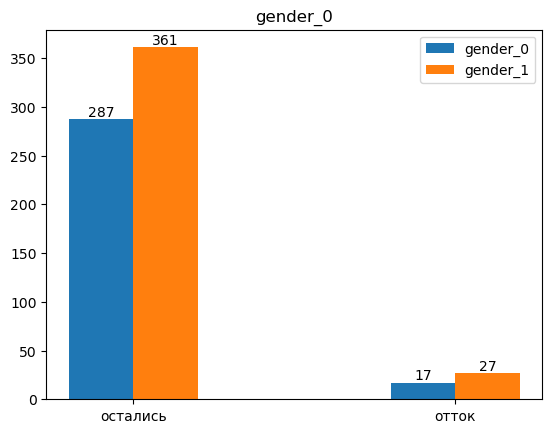

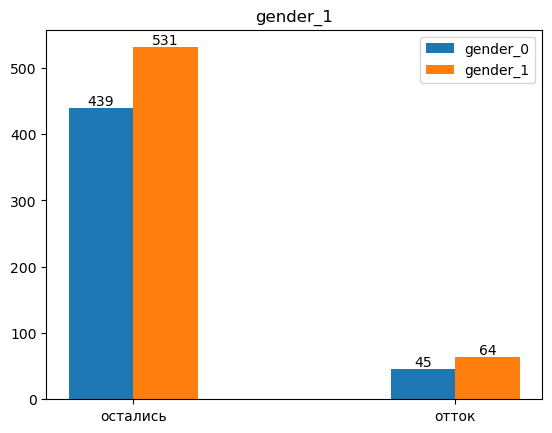

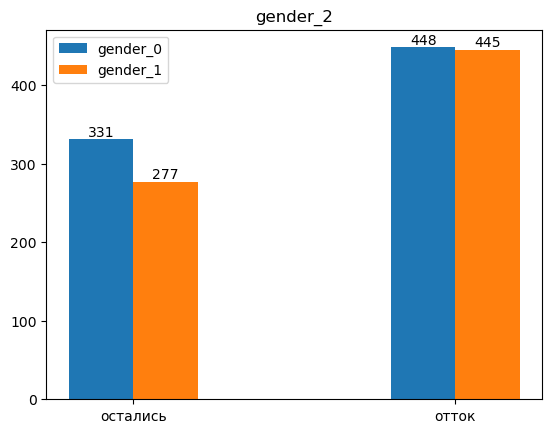

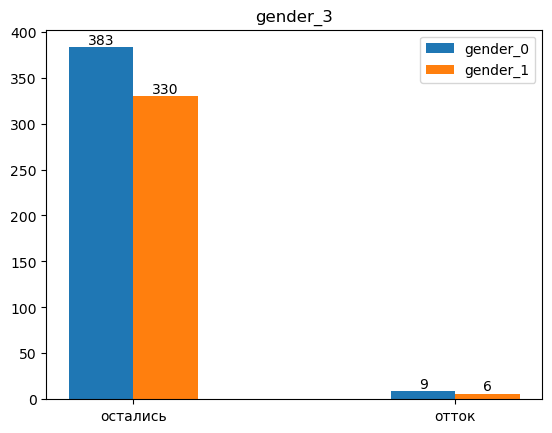

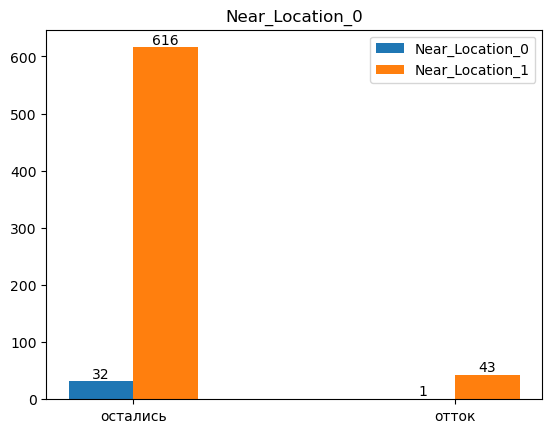

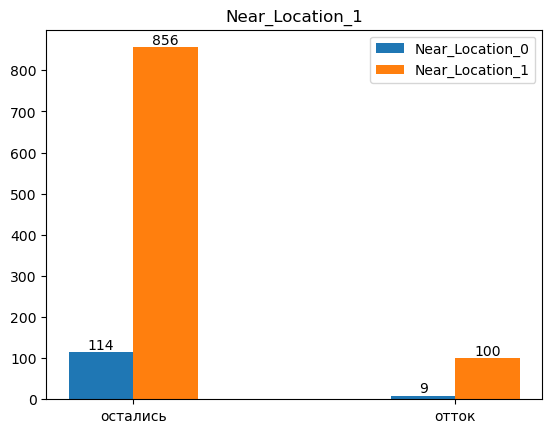

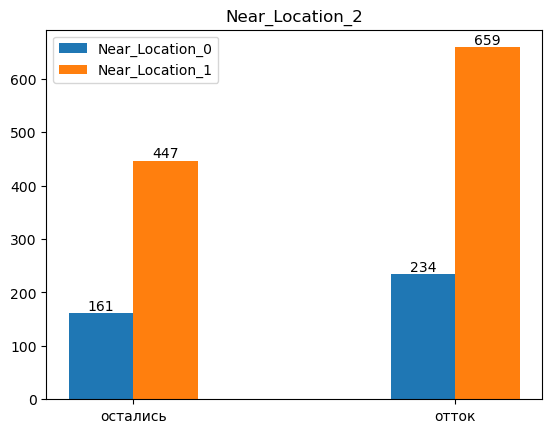

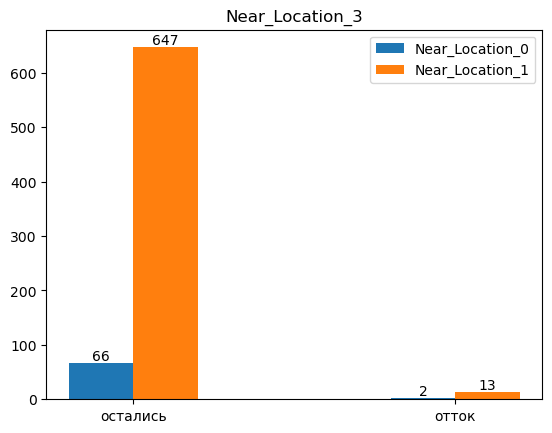

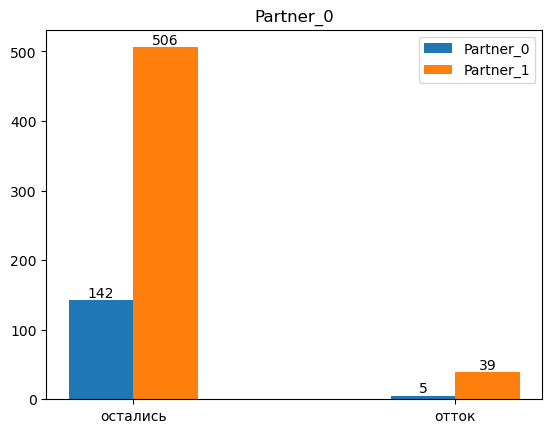

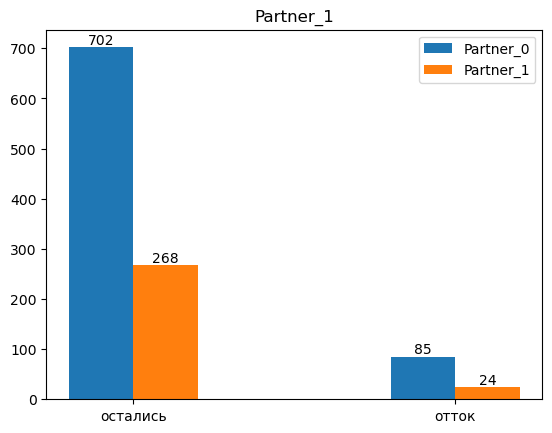

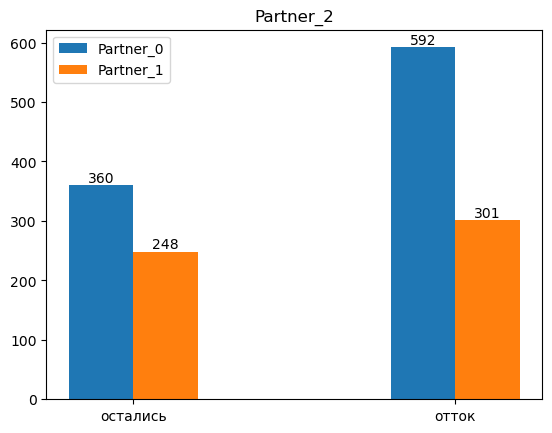

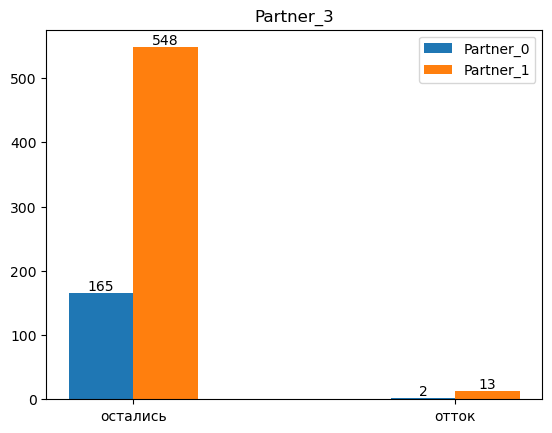

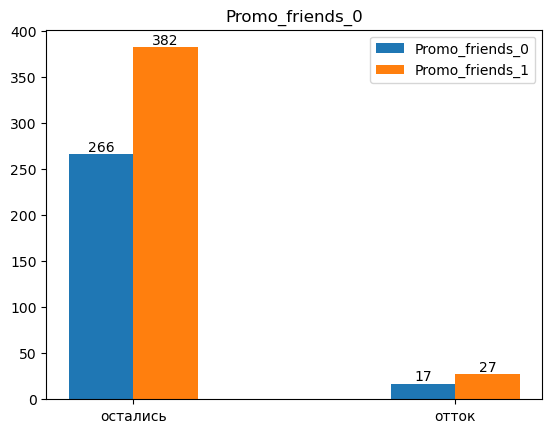

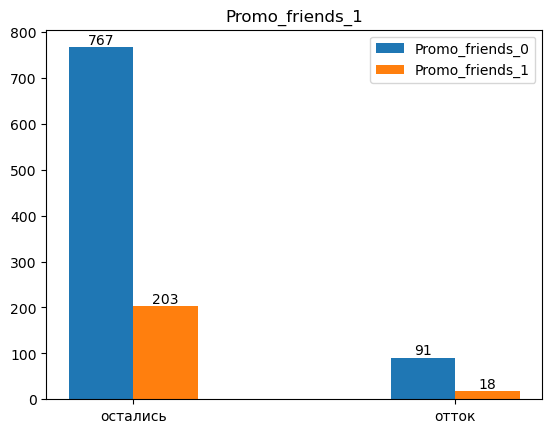

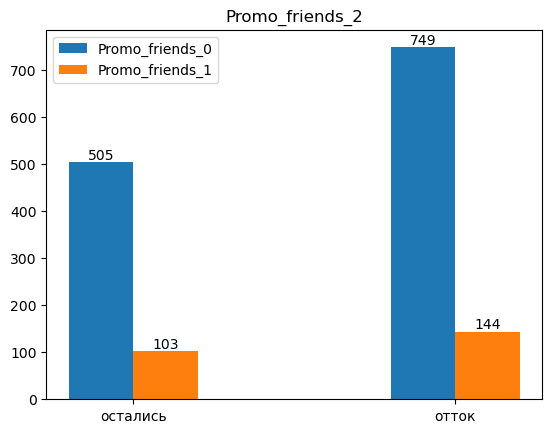

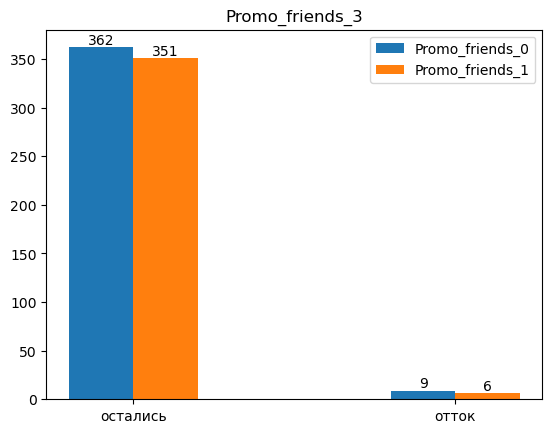

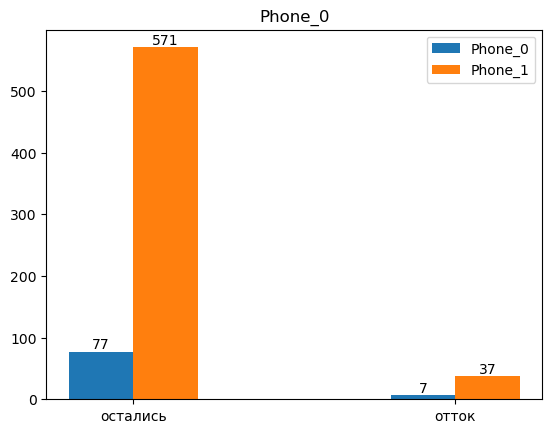

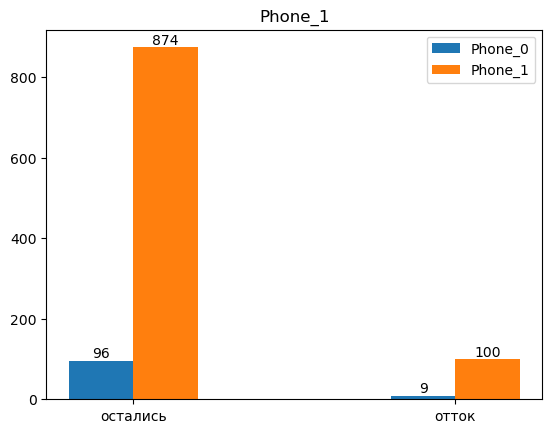

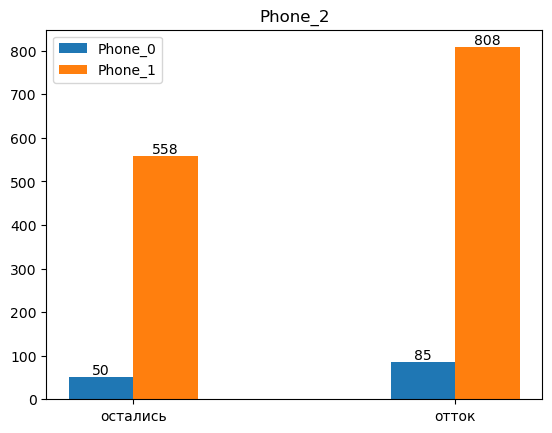

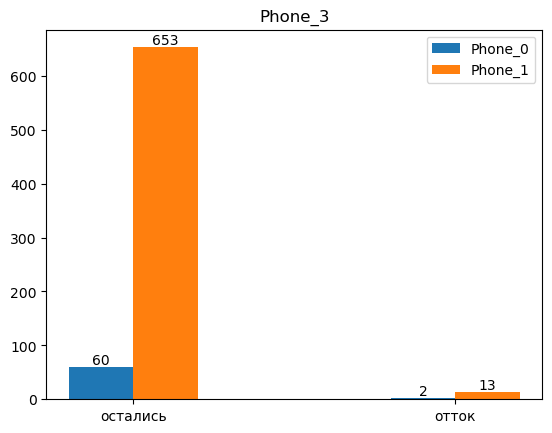

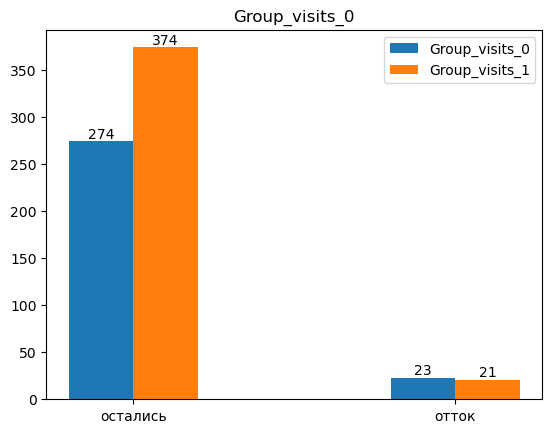

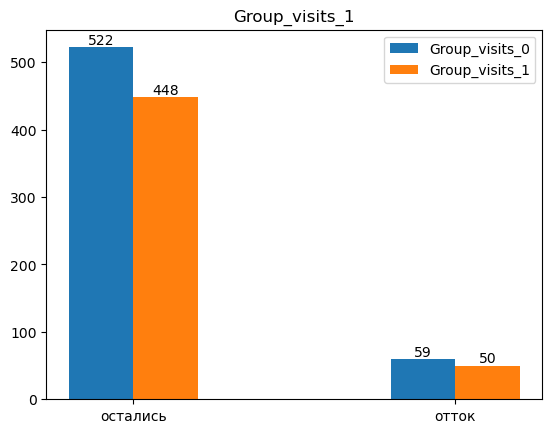

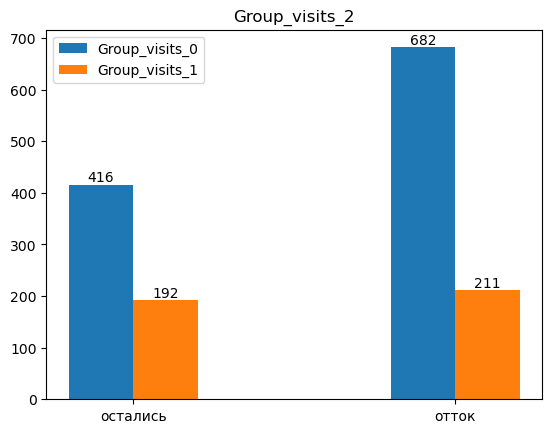

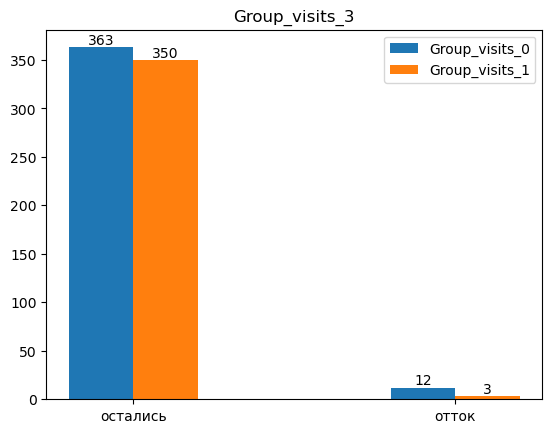

In [41]:
for i in categ:
    for j in categ_cat:
        pivo = pd.pivot_table(data = df[df['claster']==j], index = 'Churn', columns = df.iloc[:,i], values ='Age', aggfunc = 'count').reset_index()
        pivo.columns=['Churn',df.columns[i]+'_0', df.columns[i]+'_1']
        m=plt.bar(x = pivo['Churn']-0.1, height = pivo.iloc[:,1], width = 0.2, label = pivo.columns[1])
        w=plt.bar(x = pivo['Churn']+0.1, height = pivo.iloc[:,2], width = 0.2, label = pivo.columns[2])
        plt.xticks(ticks = [0,1], labels = ['остались','отток'])
        plt.legend()
        plt.bar_label(m)
        plt.bar_label(w)
        plt.title(df.columns[i]+'_%i' %j)
        plt.show()

In [43]:
cor = df.corr()
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(cor, annot = True, fmt = ".2f")

<Axes: >

In [44]:
df.groupby(by = 'claster').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
claster,,,,,,,,,,,,,,
0,0.560694,0.952312,0.787572,0.591040,0.878613,9.637283,0.570809,29.697977,159.809718,8.843931,4.735549,1.103548,1.080087,0.063584
1,0.551437,0.886006,0.270621,0.204819,0.902688,1.974977,0.461538,29.999073,156.749658,1.881372,4.801668,2.624929,2.607090,0.101019
2,0.481013,0.736842,0.365756,0.164557,0.910060,1.603598,0.268488,27.983344,127.472871,1.538308,2.057961,1.250957,0.978135,0.594937
3,0.461538,0.906593,0.770604,0.490385,0.914835,10.326923,0.484890,29.964286,160.325447,9.384615,4.604396,2.805548,2.801590,0.020604


Рекомендации для маркетинговой стратегии по группам клиентов:

Группа 0: фитнес клуб расположен рядом с домом/работой. Короткий абонемент. Высокий отток. Группа с наибольшим потенциалом для удержания клиентов. Требует максимального фокуса. Предлагаемые маркетинговые действия: предложение скидок для долгосрочных абонементов. Стимулирование "приведи друга".
Группа 1: основная характеристика - фитнес клуб не расположен рядом с домом/работой. При этом являются сотрудниками компаний-партнеров. Характерен короткий абонемент.Уровень оттока высокий. Предлагаемые маркетинговые действия: отказаться от маркетинговых усилий, таргетированных на эту группу клиентв из-за их удаленного местанохождения.
Группа 2: фитнес клуб расположен рядом с домом/работой. Короткий абонемент. Самые активные посетители. Относительно низкий отток. Предлагаемые маркетинговые действия: предложение скидок для долгосрочных абонементов. Предложение дополнительной скидки для компаний-партнеров.Стимулирование "приведи друга".
Группа 3: фитнес клуб расположен рядом с домом/работой. Длинный абонемент. Низкий отток. Самая лояльная группа. Предлагаемые маркетинговые действия: необходимо сосредоточить усилия на предложении дополнительных услуг.
Рекламная стратегия для всех групп: охват аудитории, которая живет/работает рядом. Рассылки для клиентов со сроком абонемента менее 1 месяца с предложением о продлении. Аналогичные рассылки для ушеших клиентов. Расширение взаимодействия с компаниями-партнерами.

In [ ]:
df["Население Группа"] = pd.cut(
    df["Area Population"],
    bins = [0,20000,50000,df["Area Population"].max()],
    labels = ["Мало","Средне","Много"]
)
df.groupby("Население группа")["Avg. Area Number of Bedrooms"].mean()
result = df.groupby("Население группа")["Avg. Area Number of Bedrooms"].mean()

plt.bar(result.index,result.values)
plt.title("Среднее число спален по плотности населения")
plt.xlabel("Группа по населению")
plt.ylabel("Среднее число спален")
plt.grid(axis = "y",linestyle="-",alpha=1)
plt.show()